In [1]:
from deap import algorithms, base, benchmarks, tools, creator

In [2]:
import numpy as np
import pandas as pd
import array, random

In [3]:
import wfg

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
%config InlineBackend.figure_format = 'retina'

In [6]:
problems = {'wfg1': wfg.wfg1_problem_instance, 
            'wfg2': wfg.wfg2_problem_instance, 
            'wfg3': wfg.wfg3_problem_instance, 
            'wfg4': wfg.wfg4_problem_instance, 
            'wfg5': wfg.wfg5_problem_instance, 
            'wfg6': wfg.wfg6_problem_instance, 
            'wfg7': wfg.wfg7_problem_instance, 
            'wfg8': wfg.wfg8_problem_instance, 
            'wfg9': wfg.wfg9_problem_instance}

In [18]:
distance = 20                   # number of distance-related parameters(l) l==> {2, 4, 6,...} for WFG2 and WFG3
position = 4                    # number of position-related parameters(k) k==> {2(M-1), 3(M-1),...}
num_objs = 2                  # number of objectives(M) k+l >= M
num_vars = distance + position      # number of problem variables

In [19]:
for problem_name in sorted(problems):
    f, bounds, sol_f = problems[problem_name](distance, position, num_objs)
    print(problem_name, f((np.random.rand(24))))

wfg1 [1.0044072476444503, 4.6925768988378547]
wfg2 [0.66754047701512076, 4.6209679807445943]
wfg3 [0.96220409498414328, 4.07875174641869]
wfg4 [2.1846513085911861, 3.7857222072810761]
wfg5 [1.2806809344257257, 3.3417969795026718]
wfg6 [0.94895885149056647, 3.5982106507930012]
wfg7 [2.9294091426663167, 1.5622816307505623]
wfg8 [0.98719974087126416, 4.3379171278005852]
wfg9 [0.6957402350953474, 4.219941795488778]


# Two objectives problems

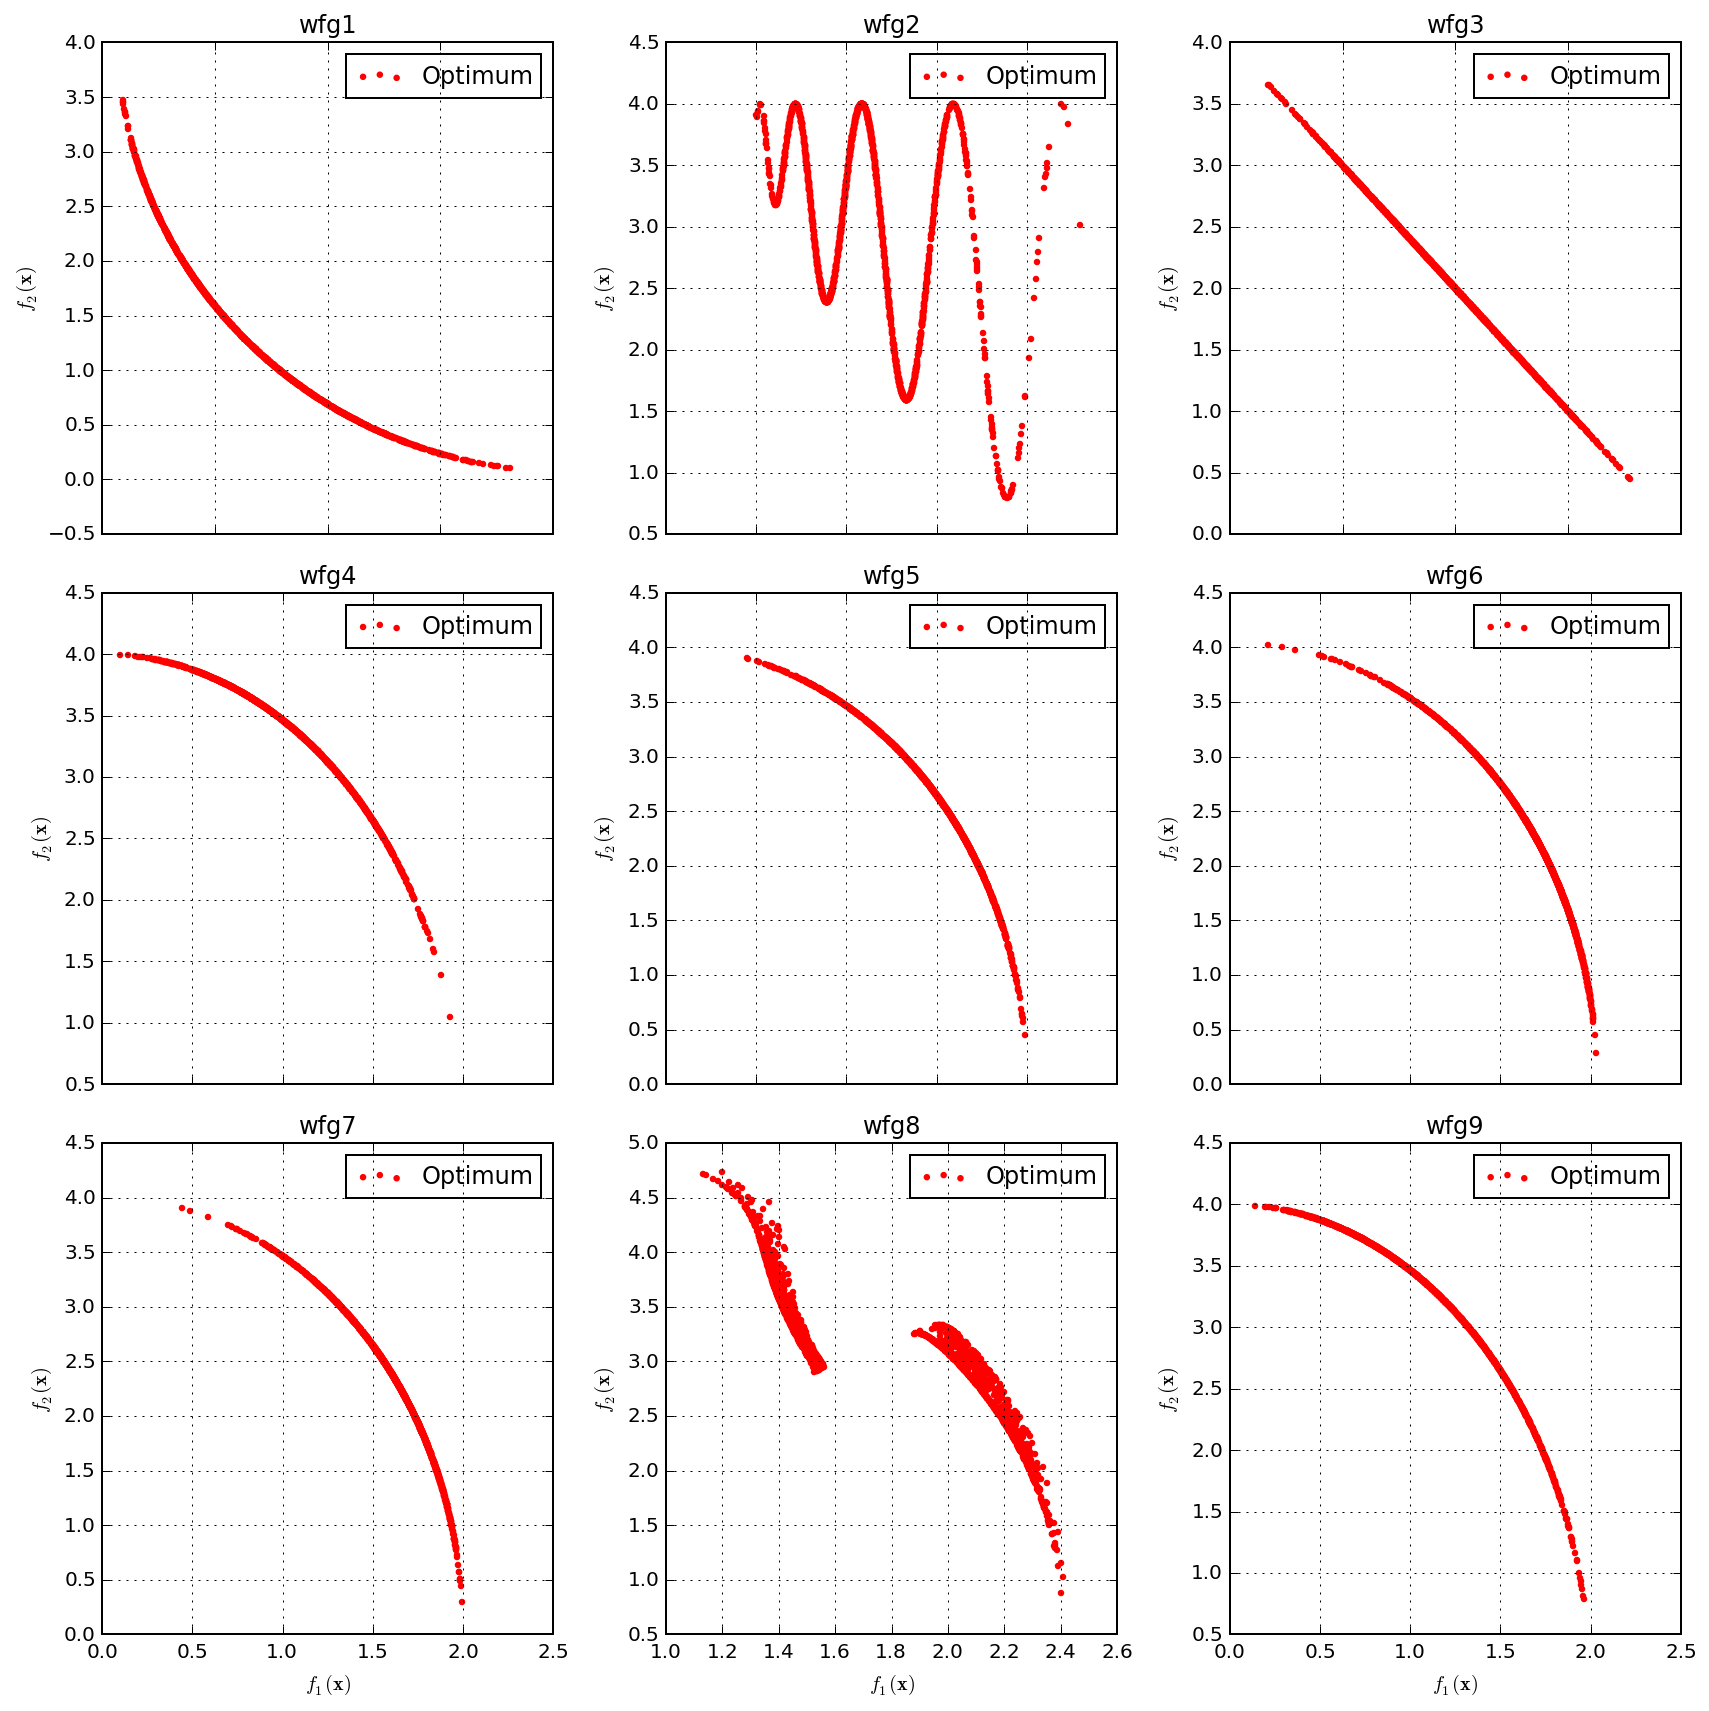

In [21]:
plt.figure(figsize=(4*(len(problems)//3),4*3))
for i, problem_name in enumerate(sorted(results)):
    ax = plt.subplot(len(problems)//3, 3, i+1)
    f, (bound_low, bound_high), sol_f = problems[problem_name](distance, position, num_objs)
    
    opt = [f(sol_f()) for _ in range(2000)]

    df = pd.DataFrame(opt)
    df.plot(ax=ax, kind='scatter', label='Optimum', marker='.',
        x=df.columns[0], y=df.columns[1], 
        color='r')
    
    plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$')
    plt.title(problem_name)
    
plt.tight_layout()

In [9]:
creator.create("FitnessMin2D", base.Fitness, weights=(-1.,-1.))
creator.create("Individual", array.array, typecode='d',fitness=creator.FitnessMin2D)

In [10]:
def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

In [11]:
def nsga_ii(toolbox, stats=None, verbose=False):
    
    toolbox.register("attr_float", uniform, 
                     toolbox.bounds_low, toolbox.bounds_high,
                     num_vars)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, 
                     low=toolbox.bounds_low, up=toolbox.bounds_high, eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, 
                     low=toolbox.bounds_low, up=toolbox.bounds_high, eta=20.0, indpb=1.0/num_vars)
    toolbox.register("select", tools.selNSGA2)
    
    toolbox.pop_size = 100
    toolbox.max_gen = 1000
    toolbox.mut_prob = 0.1
    
    pop = toolbox.population(n=toolbox.pop_size)
    pop = toolbox.select(pop, len(pop))
    return algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=1-toolbox.mut_prob,
                                     mutpb=toolbox.mut_prob, 
                                     stats=stats, 
                                     ngen=toolbox.max_gen, 
                                     verbose=verbose)

In [12]:
%%time
num_objs = 2
results = {}
for problem_name in problems:
    f, (bounds_low, bounds_high), sol_f = problems[problem_name](distance, position, num_objs)
    
    toolbox = base.Toolbox()
    toolbox.register('evaluate', f)
    toolbox.bounds_low = bounds_low
    toolbox.bounds_high = bounds_high
    
    res,_ = nsga_ii(toolbox)
    results[problem_name] = res

CPU times: user 13min 11s, sys: 4.91 s, total: 13min 16s
Wall time: 19min 5s


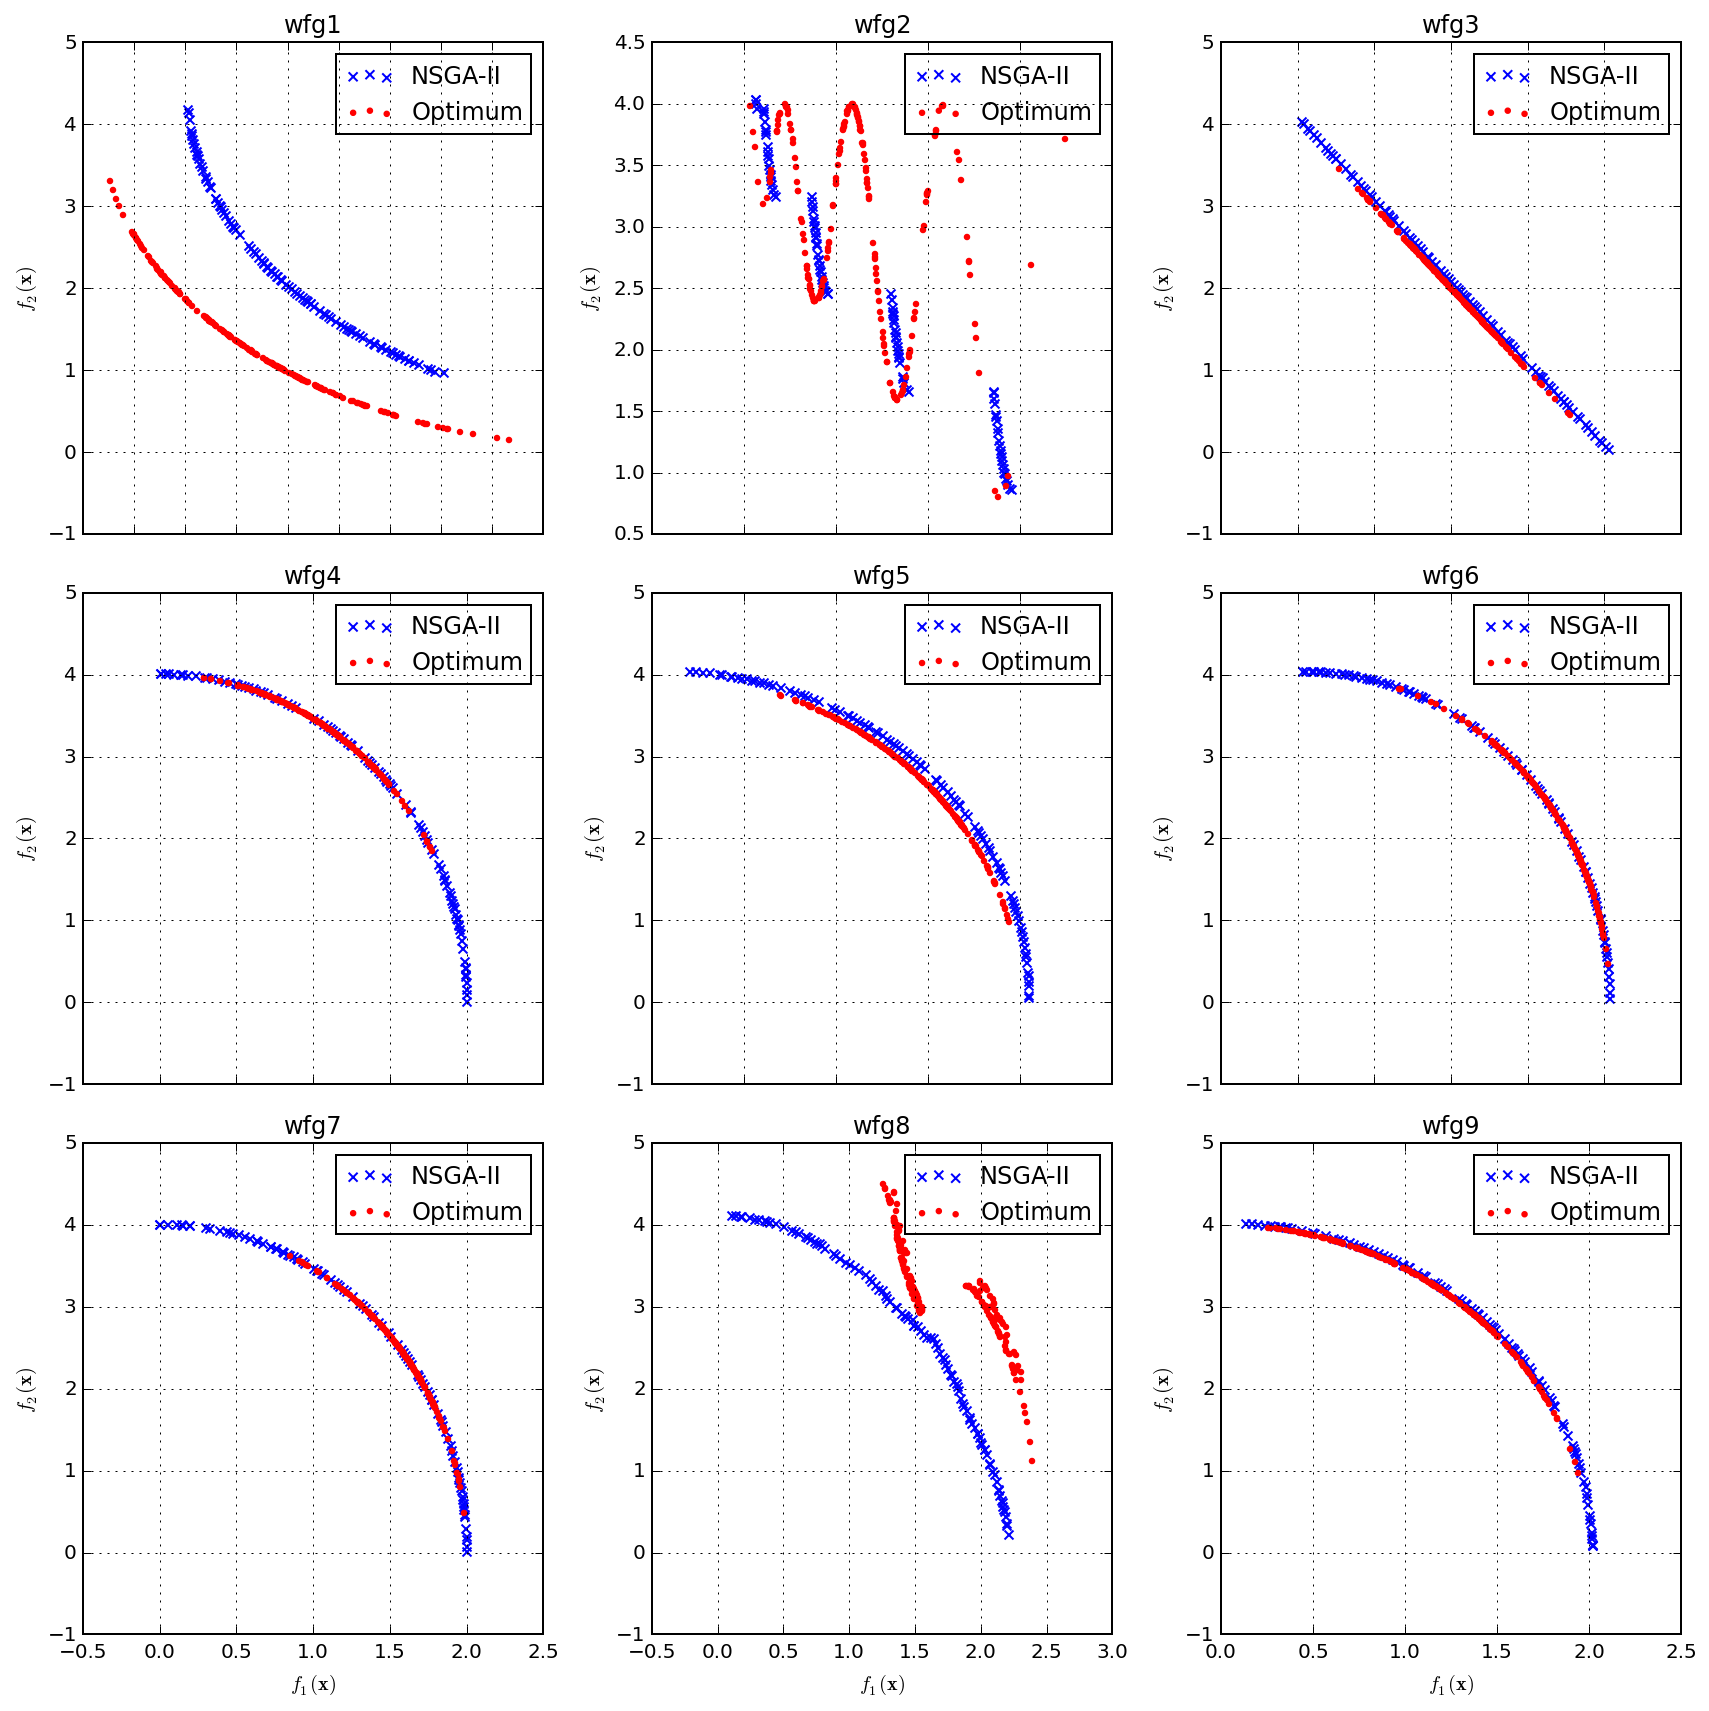

In [13]:
plt.figure(figsize=(4*(len(problems)//3),4*3))
for i, problem_name in enumerate(sorted(results)):
    ax = plt.subplot(len(problems)//3, 3, i+1)
    par = [ind.fitness.values for ind in results[problem_name]]
    df = pd.DataFrame(par)
    df.plot(ax=ax, kind='scatter', label='NSGA-II', marker='x', x=df.columns[0], y=df.columns[1], color='b')
    
    f, (bound_low, bound_high), sol_f = problems[problem_name](distance, position, num_objs)
    
    opt = [f(sol_f()) for _ in range(200)]

    df = pd.DataFrame(opt)
    df.plot(ax=ax, kind='scatter', label='Optimum', marker='.',
        x=df.columns[0], y=df.columns[1], 
        color='r')
    
    plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$')
    plt.title(problem_name)
    
plt.tight_layout()

# Three-objective problem

In [ ]:
num_objs = 3

In [ ]:
for problem_name in problems:
    f, _, _ = problems[problem_name](distance, position, num_objs)
    print(problem_name, f((np.random.rand(24))))

In [ ]:
creator.create("FitnessMin3D", base.Fitness, weights=(-1.,-1.,-1.))
creator.create("Individual3D", array.array, typecode='d',fitness=creator.FitnessMin3D)

In [17]:
%%time
results_3d = {}
for problem_name in problems:
    f, (bounds_low, bounds_high), sol_f = problems[problem_name](distance, position, num_objs)
    
    toolbox = base.Toolbox()
    toolbox.register('evaluate', f)
    toolbox.bounds_low = bounds_low
    toolbox.bounds_high = bounds_high

    res,_ = nsga_ii(toolbox)
    
    results_3d[problem_name] = res

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(4*(len(problems)//3),4*3))
for i, problem_name in enumerate(sorted(results_3d)):
    ax = fig.add_subplot(len(problems)//3,3,i+1, projection='3d')
    par = [ind.fitness.values for ind in results_3d[problem_name]]
    df = pd.DataFrame(par)
    
    ax.scatter(df[df.columns[0]].values, df[df.columns[1]].values, df[df.columns[2]].values, 
               marker='.', color='b', label='NSGA-II')
    
    f, (bound_low, bound_high), sol_f = problems[problem_name](distance, position, num_objs)
    
    opt = [f(sol_f()) for _ in range(200)]

    df = pd.DataFrame(opt)
    ax.scatter(df[df.columns[0]].values, df[df.columns[1]].values, df[df.columns[2]].values, 
               marker='.', color='r', label='Optimum sample')
    
    ax.set_xlabel('$f_1(\mathbf{x})$')
    ax.set_ylabel('$f_2(\mathbf{x})$')
    ax.set_zlabel('$f_3(\mathbf{x})$')
    plt.title(problem_name)
    
plt.tight_layout()

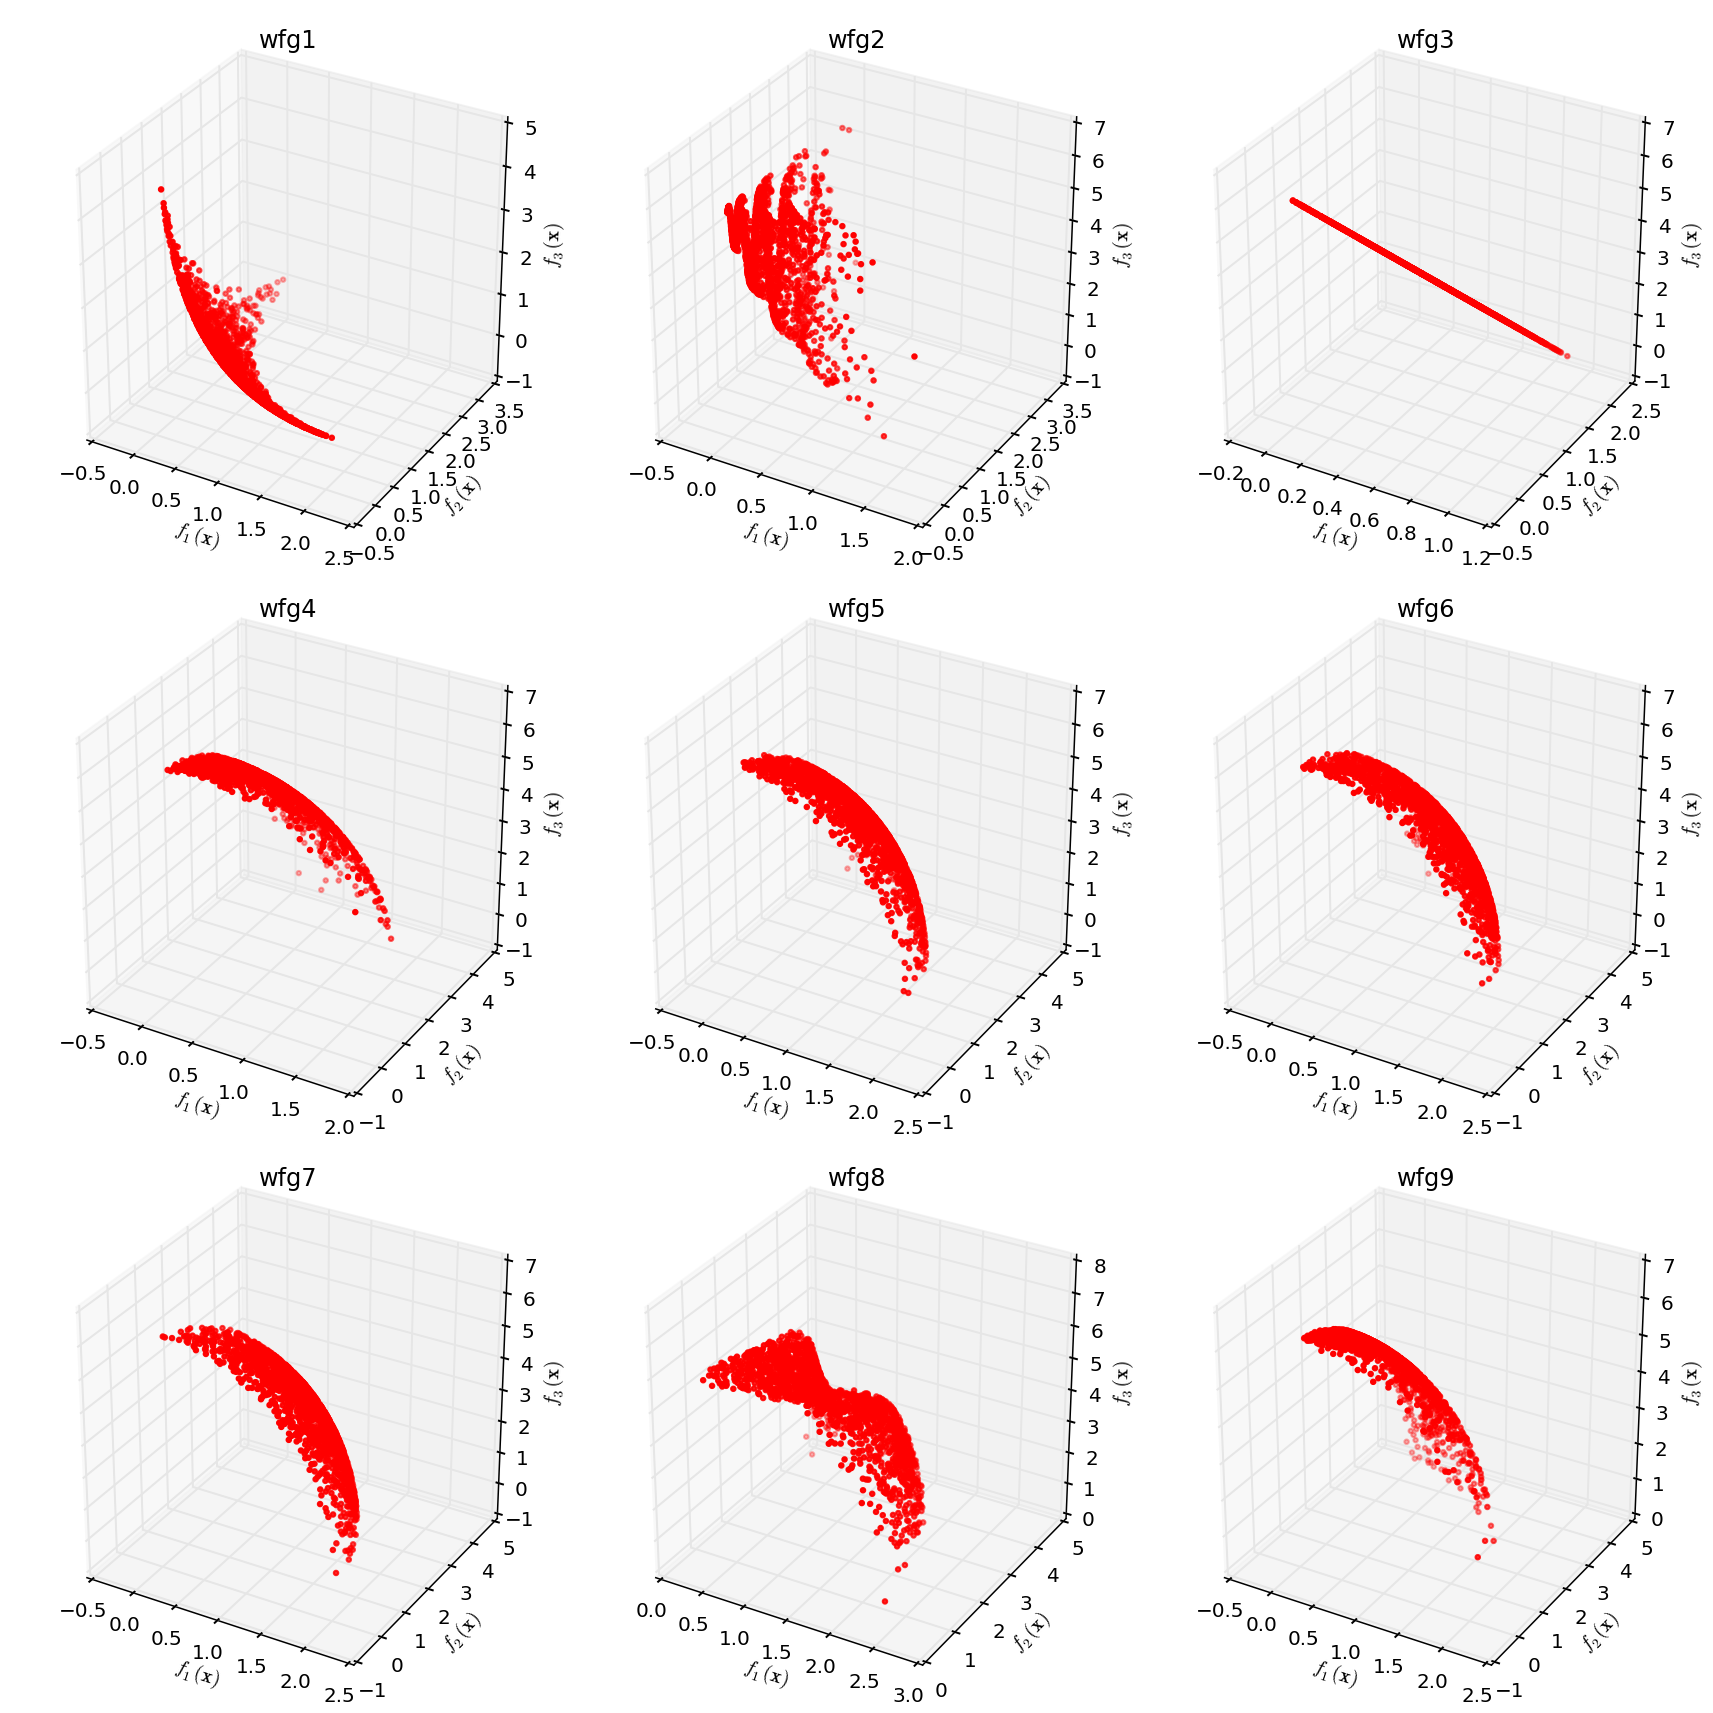

In [24]:
fig = plt.figure(figsize=(4*(len(problems)//3),4*3))
for i, problem_name in enumerate(sorted(problems)):
    ax = fig.add_subplot(len(problems)//3,3,i+1, projection='3d')
    
    f, (bound_low, bound_high), sol_f = problems[problem_name](distance, position, 3)
    
    opt = [f(sol_f()) for _ in range(2000)]

    df = pd.DataFrame(opt)
    ax.scatter(df[df.columns[0]].values, df[df.columns[1]].values, df[df.columns[2]].values, 
               marker='.', color='r', label='Optimum sample')
    
    ax.set_xlabel('$f_1(\mathbf{x})$')
    ax.set_ylabel('$f_2(\mathbf{x})$')
    ax.set_zlabel('$f_3(\mathbf{x})$')
    plt.title(problem_name)
    
plt.tight_layout()

How they should look like:

<table>
<tr>
<td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg1b.jpg'/>
</td><td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg2b.jpg'/>
</td><td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg3b.jpg'/>
</td>
</tr>
<tr><td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg4b.jpg'/>
</td><td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg5b.jpg'/>
</td><td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg6b.jpg'/>
</tr>
<tr>
<td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg7b.jpg'/>
</td><td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg8b.jpg'/>
</td><td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg9b.jpg'/>
</td>
</tr>
</table>